# NF2 viz

In [ ]:
import os 
import numpy as np 
import pyvista as pv
import matplotlib.pyplot as plt

from tvtk.api import tvtk, write_data

from nf2.evaluation.metric import *
from nf2.evaluation.unpack import load_cube
from nf2.potential.potential_field import get_potential_field

In [ ]:
res_path = 'res'
os.makedirs(res_path, exist_ok=True)

In [ ]:
save_path = '/home/tensor/workspace/GPUserver/workspace/NF2/example/ar_7115_2017-09-06T08:36:00/20170906_083600_TAI.nf2'

In [ ]:
npy_path = os.path.join(res_path, 'B.npy')
vtk_path = os.path.join(res_path, 'B.vtk')

In [ ]:
npyp_path = os.path.join(res_path, 'Bp.npy')
vtkp_path = os.path.join(res_path, 'Bp.vtk')

## Read & Create vtk

In [ ]:
def save_npy(B, npy_path):
    with open(npy_path, 'wb') as f:
        np.save(f, B)

In [ ]:
def evals(npy_path):
    with open(npy_path, 'rb') as f:
        B = np.load(f)
    n_div = (np.abs(divergence(B)) / vector_norm(B)).mean()
    theta = weighted_theta(B)

    print('DIVERGENCE [1/pix]: %.04f; THETA [deg] %.04f' % (n_div, theta))

    plt.close()
    plt.imshow(B[:, :, 0, 2].transpose(), origin='lower')
    plt.show()

In [ ]:
def save_vtk(npy_path, vtk_path):
    with open(npy_path, 'rb') as f:
        B = np.load(f)
    Nx, Ny, Nz, _ = B.shape
    bin = 2
    Mm_per_pix=360e-3
    pts = np.stack(np.mgrid[0:Nx, 0:Ny, 0:Nz], -1).astype(np.int64) * Mm_per_pix * bin
    pts = pts.transpose(2, 1, 0, 3)
    pts = pts.reshape((-1, 3))
    vectors = B.transpose(2, 1, 0, 3)
    vectors = vectors.reshape((-1, 3))

    sg = tvtk.StructuredGrid(dimensions=(Nx, Ny, Nz), points=pts)
    sg.point_data.vectors = vectors
    sg.point_data.vectors.name = 'B'

    scalars = np.linalg.norm(vectors, axis=-1)
    sg.point_data.add_array(scalars)
    sg.point_data.get_array(1).name = 'mag'
    sg.point_data.update()
    
    write_data(sg, vtk_path)

In [ ]:
B = load_cube(save_path, progress=True)

100%|██████████| 12329/12329 [00:12<00:00, 1002.67it/s]


In [ ]:
B.shape

(344, 224, 160, 3)

DIVERGENCE [1/pix]: 0.0040; THETA [deg] 20.5248


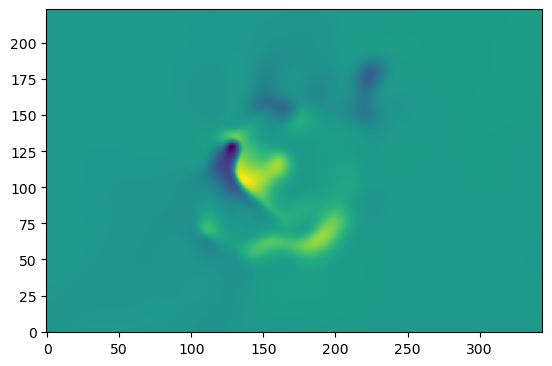

In [ ]:
save_npy(B, npy_path)
evals(npy_path)
save_vtk(npy_path, vtk_path)

In [ ]:
Bp = get_potential_field(B[:, :, 0, 2], B.shape[2])

Potential Field: 100%|██████████| 6020/6020 [05:48<00:00, 17.28it/s]


/home/tensor/mambaforge/envs/zpinn/lib/python3.10/site-packages/nf2/evaluation/metric.py:46: RuntimeWarning: invalid value encountered in divide
  sigma = vector_norm(lorentz_force(b, j)) / vector_norm(b) / vector_norm(j)


DIVERGENCE [1/pix]: 0.0006; THETA [deg] nan


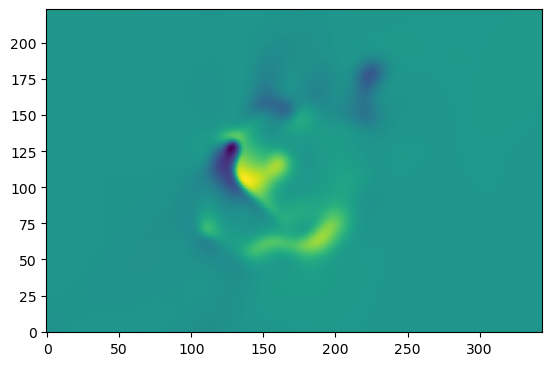

In [ ]:
save_npy(Bp, npyp_path)
evals(npyp_path)
save_vtk(npy_path, vtkp_path)

## Visualization

In [ ]:
mesh = pv.read(vtk_path)

In [ ]:
mesh

StructuredGrid (0x7fcd78294ee0)
  N Cells:      12161751
  N Points:     12328960
  X Bounds:     0.000e+00, 2.470e+02
  Y Bounds:     0.000e+00, 1.606e+02
  Z Bounds:     0.000e+00, 1.145e+02
  Dimensions:   344, 224, 160
  N Arrays:     2

In [ ]:
Nx, Ny, Nz = mesh.dimensions

### bottom (extract_subset)

In [ ]:
x_ind_min, y_ind_min, z_ind_min = 0, 0, 0
Nx, Ny, Nz = mesh.dimensions
x_ind_max, y_ind_max, z_ind_max = Nx-1, Ny-1, Nz-1

bottom_subset = (x_ind_min, x_ind_max, y_ind_min, y_ind_max, 0, 0)
bottom = mesh.extract_subset(bottom_subset).extract_surface()
bottom.active_vectors_name = 'B'
bottom.active_scalars_name = 'mag'

bottom

PolyData (0x7fcd781b3460)
  N Cells:    76489
  N Points:   77056
  N Strips:   0
  X Bounds:   0.000e+00, 2.470e+02
  Y Bounds:   0.000e+00, 1.606e+02
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   4

In [ ]:
x_bottom = bottom.points[:, 0].reshape(Nx, Ny)
y_bottom = bottom.points[:, 1].reshape(Nx, Ny)
B_bottom = bottom['B'].reshape(Nx, Ny, 3)

<matplotlib.image.AxesImage>

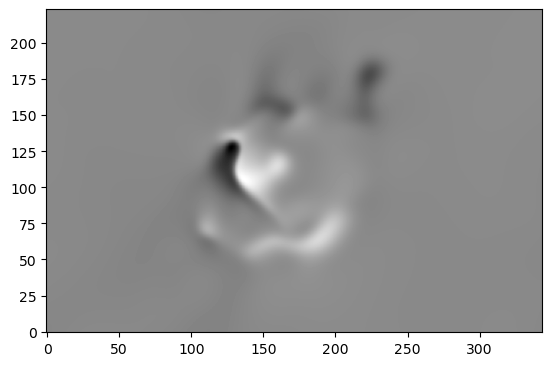

In [ ]:
plt.imshow(B_bottom[:, :, 2].transpose(), origin='lower', cmap='gray')

### bottom (ndarray)

In [ ]:
Bb = mesh['B'].reshape(Nz, Ny, Nx, 3)

In [ ]:
Bb = Bb.transpose(2, 1, 0, 3)

<matplotlib.image.AxesImage>

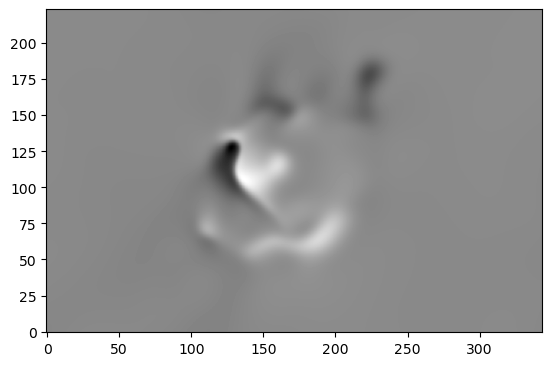

In [ ]:
plt.imshow(Bb[:, :, 0, 2].transpose(), origin='lower', cmap='gray')

In [ ]:
n_div = (np.abs(divergence(Bb)) / vector_norm(Bb)).mean()
theta = weighted_theta(Bb)

print('DIVERGENCE [1/pix]: %.04f; THETA [deg] %.04f' % (n_div, theta))

DIVERGENCE [1/pix]: 0.0040; THETA [deg] 20.5248


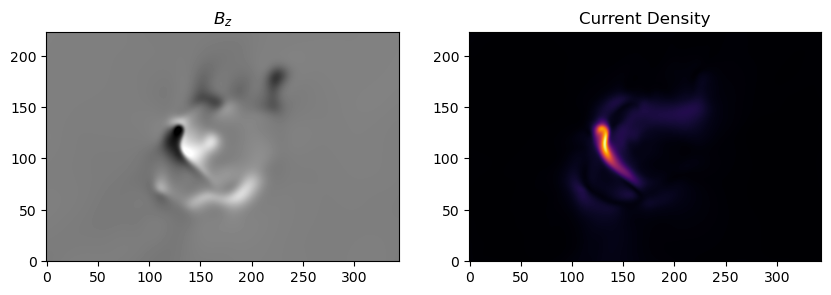

In [ ]:
j = curl(Bb)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(Bb[:, :, 0, 2].T, origin='lower', vmin=-2500, vmax=2500, cmap='gray')
plt.title('$B_z$')
plt.subplot(122)
plt.imshow(vector_norm(j).sum(2).T, origin='lower', cmap='inferno')
plt.title('Current Density')
plt.show()

## draw_grid

In [ ]:
from zpinn.pinn_nf2_visualization import draw_grid

In [ ]:
B_mesh = pv.read(vtk_path) 
Bp_mesh = pv.read(vtkp_path)

In [ ]:
B_grid = draw_grid(B_mesh)
Bp_grid = draw_grid(Bp_mesh)

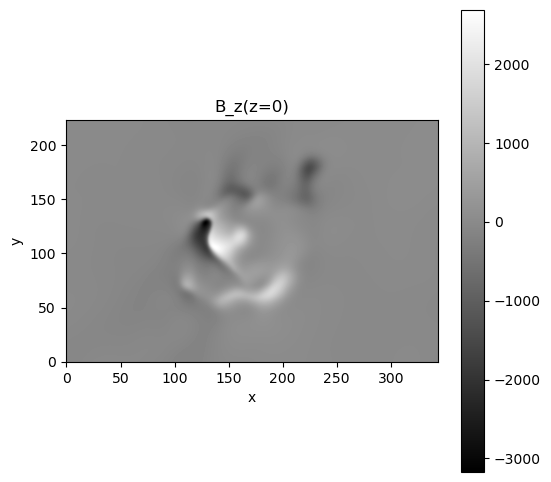

In [ ]:
B_grid.plt_Bz_imshow(z=0)

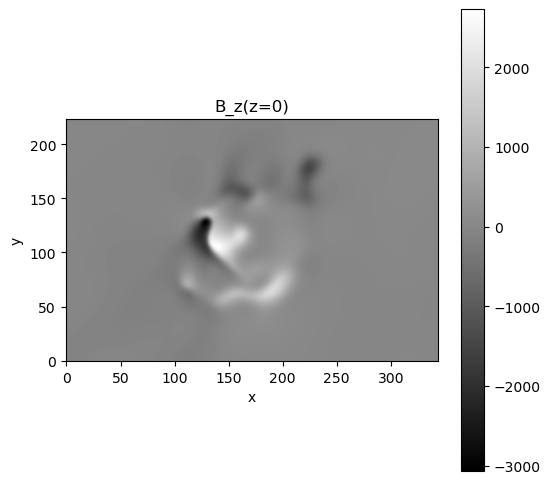

In [ ]:
Bp_grid.plt_Bz_imshow(z=0)

/home/tensor/mambaforge/envs/zpinn/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame_vtk.tools'

Falling back to a static output.
  warnings.warn(


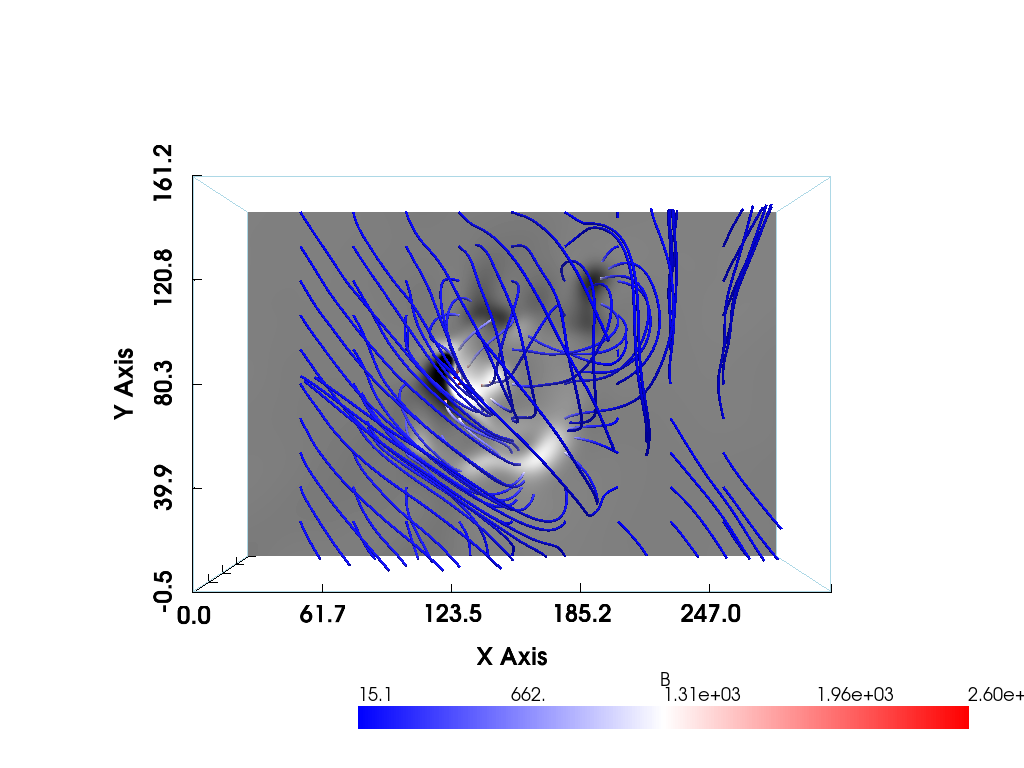

In [ ]:
B_grid.pv_streamline_Bz(camera_position='xy')

/home/tensor/mambaforge/envs/zpinn/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame_vtk.tools'

Falling back to a static output.
  warnings.warn(


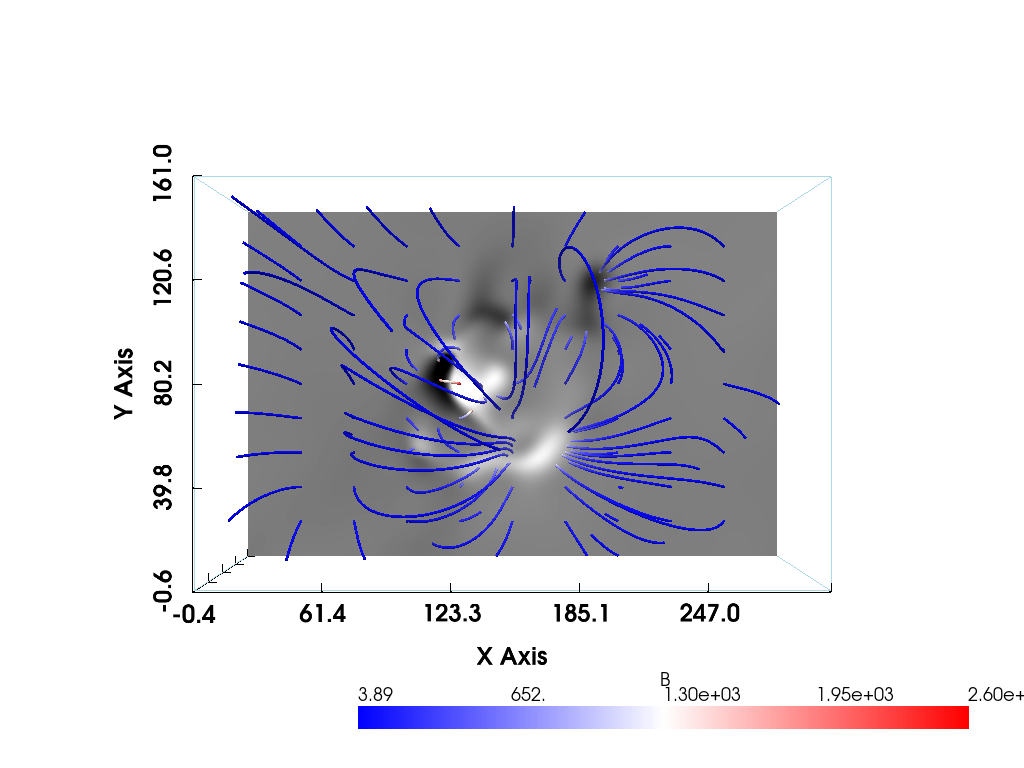

In [ ]:
Bp_grid.pv_streamline_Bz(camera_position='xy')